# The Finite Difference Method: 1D steady state heat transfer

These examples are based on code originally written by Krzysztof Fidkowski and adapted by Venkat Viswanathan. 

In [134]:
import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.config import config
from jax.scipy.linalg import solve
from scipy.optimize import minimize

config.update("jax_enable_x64", True)  # Enable 64-bit precision for better numerical stability

import matplotlib.pyplot as plt
import niceplots

plt.style.use(niceplots.get_style())


This code implements the example case from section 3.1.1 of the course notes.

We will solve the steady state heat transfer equation in 1D:

$$ -\kappa\frac{d^2T}{dx^2} = q(x) $$

where $\kappa$ is the thermal conductivity, $T$ is the temperature, $x$ is the position, and $q(x)$ is a heat source term, which in this case is $\sin\left(\pi x /L\right)$.


In [135]:
# Define the symbolic function q(x)
def q(x, L):
    return jnp.sin(jnp.pi * x / L)


The 1D domain spans $0 \le x \le L$ and is split into $N$ intervals of length $\Delta x = L/N$, this gives $N+1$ nodes in the grid. The temperatures at the nodes are $T_0, T_1, \ldots, T_N$. Dirichlet boundary conditions are applied at $x=0$ and $x=L$, such that $T_0 = 1$ and $T_N=4$.

![The finite-difference grid](../../images/FDDomain.svg)

Using the central difference approximation for the second derivative, we can write the equation at each node as:

$$ -\kappa\frac{T_{i-1} - 2T_i + T_{i+1}}{\Delta x^2} = q(x_i) \Rightarrow -T_{i-1} + 2T_i - T_{i+1} = \frac{1}{\kappa} \Delta x^2 q(x_i)$$

We will enforce this equation at all nodes except the boundary nodes, which have known temperatures. This gives $N-1$ equations for the $N+1$ unknown temperatures. At nodes $i=1$ and $i=N-1$, we have to rearrange the equation to account for the known temperature values that appear in the finite difference stencil:

$$\text{at } i=1, \quad 2T_1 - T_2 = \frac{1}{\kappa} \Delta x^2 q(x_i) + T_0$$
$$\text{at } i=N-1, \quad -T_{N-2} + 2T_{N-1} = \frac{1}{\kappa} \Delta x^2 q(x_i) + T_N$$

Writing this all up in matrix-form we get:

$$\begin{bmatrix}
2 & -1 & 0 & 0 & \cdots & 0 \\
-1 & 2 & -1 & 0 & \cdots & 0 \\
0 & -1 & 2 & -1 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & \cdots & 0 & -1 & 2 & -1 \\
0 & \cdots & 0 & 0 & -1 & 2
\end{bmatrix}
\begin{bmatrix}
T_1 \\ T_2 \\ T_3 \\ \vdots \\ T_{N-1}
\end{bmatrix}
= 
\begin{bmatrix}
q(x_1) \Delta x^2 / \kappa + T_0 \\ q(x_2) \Delta x^2 / \kappa \\ q(x_3) \Delta x^2 / \kappa \\ \vdots \\ q(x_{N-1}) \Delta x^2 / \kappa + T_N
\end{bmatrix}
$$

Alternatively, we can keep the boundary nodes in the matrix equation, and enforce the boundary conditions using the first and last rows of the matrix:

$$\begin{bmatrix}
1 & 0 & 0 & 0 & \cdots & 0 \\
-1 & 2 & -1 & 0 & \cdots & 0 \\
0 & -1 & 2 & -1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & \cdots & 0 & -1 & 2 & -1 \\
0 & \cdots & 0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
T_0 \\ T_1 \\ T_2 \\ \vdots \\ T_{N-1} \\ T_{N}
\end{bmatrix}
= 
\begin{bmatrix}
T_0 \\ q(x_1)\Delta x^2 / \kappa \\ q(x_2)\Delta x^2 / \kappa \\ \vdots \\ q(x_{N-1})\Delta x^2 / \kappa \\ T_N)
\end{bmatrix}
$$

The code below implements the second approach, and solves the matrix equation using a direct sparse linear solver.

In [136]:
def heat_conduction(T_left=1.0, T_right=4.0, L=2.0, kappa=0.5, Nx=10):
    """Setup and solve the heat conduction problem using the finite difference method

    Parameters
    ----------
    T_left : float, optional
        Left boundary temperature, by default 1.0
    T_right : float, optional
        Right boundary temperature, by default 4.0
    L : float, optional
        Length of domain, by default 2.0
    kappa : float, optional
        Thermal conductivity, by default 0.5
    Nx : int, optional
        Number of intervals, by default 10

    Returns
    -------
    array
        Nodal temperature values
    array
        Nodal x coordinates
    """
    # Define the parameters
    dx = L / Nx  # Grid spacing

    # Create the matrix A (tridiagonal with 2 on the diagonal and -1 on the off-diagonals)
    diagonal = 2.0 * jnp.ones(Nx - 1)
    off_diagonal = -jnp.ones(Nx - 2)
    A = jnp.diag(diagonal) + jnp.diag(off_diagonal, k=1) + jnp.diag(off_diagonal, k=-1)

    # Add the Boundary conditions
    A = jnp.vstack((A, jnp.zeros(Nx - 1)))
    A = jnp.vstack((jnp.zeros(Nx - 1), A))
    A = jnp.column_stack([jnp.zeros(A.shape[0]), A])
    A = jnp.column_stack([A, jnp.zeros(A.shape[0])])
    A = A.at[(0, 0)].set(1.0)
    A = A.at[(-1, -1)].set(1.0)  # Set the bottom-right diagonal element to 1
    A = A.at[(1, 0)].set(-1.0)
    A = A.at[(-2, -1)].set(-1.0)  # Set the bottom-right diagonal element to 1

    # Create the vector representing the heat source (modify q(x) as needed)
    x_values = jnp.linspace(0, L, Nx + 1)
    b = jnp.zeros(Nx + 1)
    b = b.at[1:Nx].set(q(x_values[1:Nx], L) / kappa * dx**2)

    # Define boundary conditions (e.g., fixed temperature at both ends)
    T_left = 1.0
    T_right = 4.0
    b = b.at[0].set(T_left)
    b = b.at[-1].set(T_right)

    T = solve(A, b)
    return T, x_values

Now let's solve the system for $N=3$ and plot the results compared to the analytical solution:

$$T_\text{exact} (x) = \frac{L^2}{\kappa \pi^2}\sin\left(\frac{\pi x}{L}\right) + T_0 + \frac{x}{L}\left(T_N - T_0\right)$$

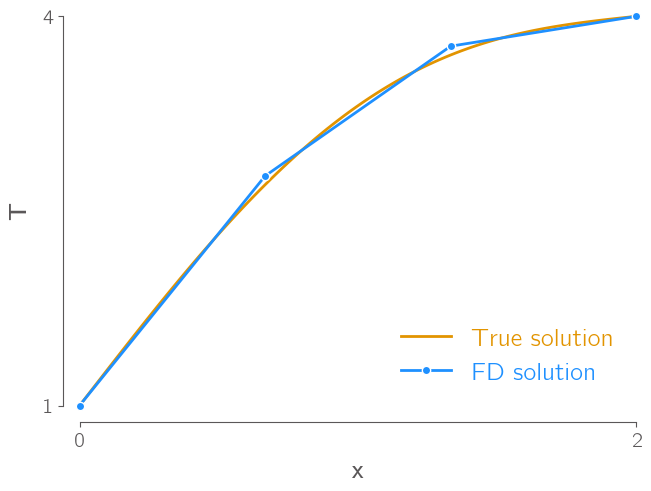

In [137]:
# Define the true solution
def true_solution(x, L, kappa, T_left, T_right):
    return L**2 / (jnp.pi**2 * kappa) * jnp.sin(jnp.pi * x / L) + T_left + (T_right - T_left) * x / L


# Define the parameters
L = 2.0  # Length of domain
kappa = 0.5  # Thermal conductivity
Nx = 3  # Number of intervals
T0 = 1.0  # Left boundary condition
TN = 4.0  # Right boundary condition

# Solve the finite difference problem
T_soln, x_vals = heat_conduction(T0, TN, L, kappa, Nx)

# Plot the results against the true solution
fig, ax = plt.subplots()
xTrue = jnp.linspace(0, 2.0, 100)
ax.plot(xTrue, true_solution(xTrue, L, kappa, T0, TN), "-", clip_on=False, label="True solution")
ax.plot(x_vals, T_soln, "-o", clip_on=False, label="FD solution")
ax.set_xlabel("$x$")
ax.set_xticks([0, L])
ax.set_ylabel("$T$")
ax.set_yticks([T0, TN])
ax.legend(labelcolor="linecolor", loc="lower right")
niceplots.adjust_spines(ax)
plt.show()

Even with only 3 intervals, the solution is already quite close to the exact solution.

## Convergence study

Since we are using a second-order accurate approximation of $\frac{d^2T}{dx^2}$, we expect the error to be proportional to $\Delta x^2$. Let's verify this by solving the system for a range of values of $N$ and plotting the error as a function of $\Delta x$.

The error is computed using the $L_2$ norm as given in chapter 1 of the course notes:

$$\text{Error} = \sqrt{\frac{1}{N+1}\sum_0^{N}\left(T_i - T_\text{exact}(x_i)\right)^2}$$

This is not equivalent to the typical $L_2$ computed by numpy/JAX, which do not normalize by the number of elements, and would therefore give the wrong order of convergence.

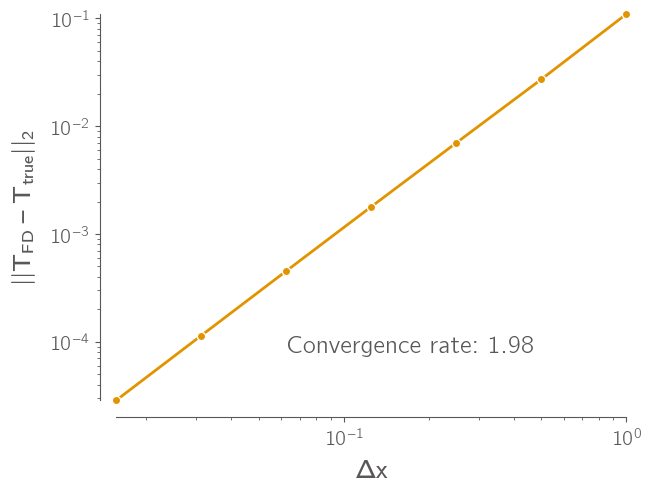

In [138]:
Nsweep = 2 ** jnp.arange(1, 8)
errors = []

for Nx in Nsweep:
    T_soln, x_vals = heat_conduction(T0, TN, L, kappa, Nx)
    error = jnp.sqrt(1 / (Nx + 1) * jnp.sum((T_soln - true_solution(x_vals, L, kappa, T0, TN)) ** 2))
    errors.append(error)

fig, ax = plt.subplots()
ax.set_xlabel("$\Delta x$")
ax.set_ylabel(r"$||T_{FD} - T_{true}||_2$")
ax.set_xscale("log")
ax.set_yscale("log")

ax.plot(L / Nsweep, errors, "-o", clip_on=False)

# Compute the convergence rate by fitting a line to the log-log plot
rate = jnp.polyfit(jnp.log(L / Nsweep), jnp.log(jnp.array(errors)), 1)[0]

ax.annotate(f"Convergence rate: {float(rate):.2f}", xy=(L / Nsweep[4], errors[5]), ha="left", va="top")

niceplots.adjust_spines(ax)

## Learning thermal conductivity from measurement data

Now we will leverage the power of JAX to solve an inverse problem: given some measured temperatures, we will try to find the value of the thermal conductivity that best matches the data.

In this case, we will generate our "experimental data" by running the FD code with a given value of $\kappa$, this way we can tell if our learning process has been successful.

In [139]:
Nx = 10
measured_temps, measurement_locations = heat_conduction(T0, TN, L, 0.5, Nx)


Next we define our "loss" or "objective" function, this is the function that we will try to minimize. In this case, we will use the $L_2$ norm of the difference between the measured temperatures and the temperatures computed by the FD code. We will also use JAX to create a function that computes $\frac{df}{d\kappa}$.

In [140]:
def obj_function(kappa):
    predicted_temps = heat_conduction(T0, TN, L, kappa, Nx)[0]
    error = jnp.linalg.norm(predicted_temps - measured_temps)
    # Print the current kappa and error, the try/except block is so that the printing is skipped when JAX AD's this function
    try:
        print(f"kappa = {float(kappa[0]): .7e}, error = {float(error): .7e}")
    except TypeError:
        pass
    return error

obj_grad = grad(obj_function)

Now we will use an algorithm called an optimizer to find the value of $\kappa$ that minimizes the objective function. For problems where we expect the objective function to be smooth, gradient-based optimizers are the most efficient methods. Here we use an optimizer provided by JAX which will use the gradient information computed by JAX's AD to find the minimum.

In [142]:
sol = minimize(obj_function, 2.349822365, jac=obj_grad, method="SLSQP", tol=1e-6)

if sol.success:
    print(f"\nSUCCEsS: My best guess at kappa is {sol.x[0]:.7e}")
else:
    print("\nFAILURE: Optimization did not converge")

kappa =  2.3498224e+00, error =  1.4386167e+00
kappa =  2.1843406e+00, error =  1.4091580e+00
kappa =  1.2268172e+00, error =  1.0826684e+00
kappa = -1.3950688e+01, error =  1.8929669e+00
kappa = -5.7485267e+00, error =  1.9864205e+00
kappa = -1.6474461e+00, error =  2.3821065e+00
kappa =  4.0309418e-01, error =  4.3933260e-01
kappa =  1.1465550e+00, error =  1.0305301e+00
kappa =  7.2877184e-01, error =  5.7366863e-01
kappa =  5.5480509e-01, error =  1.8052217e-01
kappa =  5.0238946e-01, error =  8.6917907e-03
kappa =  1.8277191e-01, error =  3.1718475e+00
kappa =  4.5958774e-01, error =  1.6069220e-01
kappa =  4.9158610e-01, error =  3.1278644e-02
kappa =  4.9896527e-01, error =  3.7897058e-03
kappa =  5.0068908e-01, error =  2.5150622e-03
kappa =  4.9983015e-01, error =  6.2101403e-04
kappa =  5.0026035e-01, error =  9.5106246e-04
kappa =  5.0000795e-01, error =  2.9059218e-05
kappa =  4.9991908e-01, error =  2.9580400e-04
kappa =  4.9998355e-01, error =  6.0116422e-05
kappa =  4.99